In [10]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet18
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from tqdm import tqdm
from PIL import Image
import cv2
import kagglehub

SEED = 429
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [11]:
# Download datasets
asl_path = kagglehub.dataset_download("grassknoted/asl-alphabet")
wlasl_path = kagglehub.dataset_download("thtrnphc/wlasl100-new")

print(f"ASL path: {asl_path}")
print(f"WLASL path: {wlasl_path}")

Using Colab cache for faster access to the 'asl-alphabet' dataset.
Using Colab cache for faster access to the 'wlasl100-new' dataset.
ASL path: /kaggle/input/asl-alphabet
WLASL path: /kaggle/input/wlasl100-new


In [12]:
# Load datasets
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Paths
asl_train_dir = os.path.join(asl_path, 'asl_alphabet_train', 'asl_alphabet_train')
asl_test_dir = os.path.join(asl_path, 'asl_alphabet_test', 'asl_alphabet_test')

# Custom dataset for flat test structure
class FlatImageDataset(Dataset):
    def __init__(self, directory, class_names, transform=None):
        self.directory = directory
        self.transform = transform
        self.class_names = class_names
        self.class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}

        self.images = []
        self.labels = []

        for filename in sorted(os.listdir(directory)):
            if filename.endswith(('.jpg', '.png', '.jpeg')):
                filepath = os.path.join(directory, filename)
                class_name = filename.split('_')[0]

                if class_name in self.class_to_idx:
                    self.images.append(filepath)
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Load datasets
full_train = datasets.ImageFolder(root=asl_train_dir, transform=train_transform)
full_test = FlatImageDataset(asl_test_dir, full_train.classes, transform=val_test_transform)

num_classes = len(full_train.classes)
class_names = full_train.classes

print(f"Training images: {len(full_train)}")
print(f"Test images: {len(full_test)}")
print(f"Classes: {num_classes}")

# Create stratified split
indices = np.arange(len(full_train))
labels = np.array(full_train.targets)

train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=labels, random_state=429)

train_subset = Subset(full_train, train_idx)
val_subset = Subset(full_train, val_idx)

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(full_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

Training images: 87000
Test images: 28
Classes: 29
Train batches: 1088, Val batches: 272, Test batches: 1


In [13]:
# Training functions
def freeze_model(model, freeze_pattern=None):
    for param in model.parameters():
        param.requires_grad = True

    if freeze_pattern == "head_only":
        for param in model.conv1.parameters():
            param.requires_grad = False
        for param in model.bn1.parameters():
            param.requires_grad = False
        for param in model.layer1.parameters():
            param.requires_grad = False
        for param in model.layer2.parameters():
            param.requires_grad = False
        for param in model.layer3.parameters():
            param.requires_grad = False
        for param in model.layer4.parameters():
            param.requires_grad = False

    elif freeze_pattern == "last_block":
        for param in model.conv1.parameters():
            param.requires_grad = False
        for param in model.bn1.parameters():
            param.requires_grad = False
        for param in model.layer1.parameters():
            param.requires_grad = False
        for param in model.layer2.parameters():
            param.requires_grad = False
        for param in model.layer3.parameters():
            param.requires_grad = False

    elif freeze_pattern == "progressive":
        for param in model.conv1.parameters():
            param.requires_grad = False
        for param in model.bn1.parameters():
            param.requires_grad = False
        for param in model.layer1.parameters():
            param.requires_grad = False
        for param in model.layer2.parameters():
            param.requires_grad = False

def set_bn_eval(model, freeze=True):
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            if freeze:
                module.eval()
            else:
                module.train()

def train_epoch(model, train_loader, criterion, optimizer, device, bn_frozen=False):
    model.train()
    if bn_frozen:
        set_bn_eval(model, freeze=True)

    total_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, acc, f1

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, acc, f1, all_preds, all_labels

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs, device, model_name, bn_frozen=False, patience=10):
    best_f1 = 0
    patience_counter = 0

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    for epoch in range(num_epochs):
        train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion,
                                                       optimizer, device, bn_frozen)
        val_loss, val_acc, val_f1, _, _ = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        if scheduler:
            scheduler.step()

        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), f"/content/{model_name}_best.pth")
            print(f"Epoch {epoch+1:2d}/{num_epochs} | Train: L={train_loss:.4f} A={train_acc:.4f} F1={train_f1:.4f} | Val: L={val_loss:.4f} A={val_acc:.4f} F1={val_f1:.4f} (Best)")
        else:
            patience_counter += 1
            print(f"Epoch {epoch+1:2d}/{num_epochs} | Train: L={train_loss:.4f} A={train_acc:.4f} F1={train_f1:.4f} | Val: L={val_loss:.4f} A={val_acc:.4f} F1={val_f1:.4f}")
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(torch.load(f"/content/{model_name}_best.pth"))
    return model, history

In [14]:
# Train T-A
model_ta = resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model_ta.fc = nn.Linear(512, num_classes)
model_ta = model_ta.to(device)

freeze_model(model_ta, freeze_pattern="head_only")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([p for p in model_ta.parameters() if p.requires_grad], lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model_ta, history_ta = train_model(model_ta, train_loader, val_loader, criterion, optimizer, scheduler,
                                    num_epochs=30, device=device, model_name="model_ta", bn_frozen=True, patience=10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 236MB/s]


Epoch  1/30 | Train: L=1.1119 A=0.7577 F1=0.7556 | Val: L=0.5989 A=0.8620 F1=0.8643 (Best)


Epoch  2/30 | Train: L=0.4872 A=0.8830 F1=0.8827 | Val: L=0.4088 A=0.8999 F1=0.9005 (Best)


Epoch  3/30 | Train: L=0.3652 A=0.9067 F1=0.9065 | Val: L=0.3395 A=0.9078 F1=0.9080 (Best)


Epoch  4/30 | Train: L=0.3068 A=0.9173 F1=0.9172 | Val: L=0.2839 A=0.9232 F1=0.9230 (Best)


Epoch  5/30 | Train: L=0.2769 A=0.9221 F1=0.9220 | Val: L=0.2662 A=0.9253 F1=0.9251 (Best)


Epoch  6/30 | Train: L=0.2445 A=0.9327 F1=0.9326 | Val: L=0.2437 A=0.9306 F1=0.9304 (Best)


Epoch  7/30 | Train: L=0.2361 A=0.9336 F1=0.9336 | Val: L=0.2274 A=0.9361 F1=0.9361 (Best)


Epoch  8/30 | Train: L=0.2257 A=0.9370 F1=0.9370 | Val: L=0.2296 A=0.9331 F1=0.9329


Epoch  9/30 | Train: L=0.2224 A=0.9367 F1=0.9367 | Val: L=0.2123 A=0.9413 F1=0.9413 (Best)


Epoch 10/30 | Train: L=0.2108 A=0.9406 F1=0.9406 | Val: L=0.2082 A=0.9398 F1=0.9397


Epoch 11/30 | Train: L=0.2020 A=0.9427 F1=0.9427 | Val: L=0.2048 A=0.9415 F1=0.9415 (Best)


Epoch 12/30 | Train: L=0.1993 A=0.9449 F1=0.9449 | Val: L=0.2017 A=0.9429 F1=0.9429 (Best)


Epoch 13/30 | Train: L=0.1972 A=0.9440 F1=0.9440 | Val: L=0.1941 A=0.9445 F1=0.9445 (Best)


Epoch 14/30 | Train: L=0.1960 A=0.9438 F1=0.9438 | Val: L=0.1923 A=0.9461 F1=0.9461 (Best)


Epoch 15/30 | Train: L=0.1887 A=0.9467 F1=0.9467 | Val: L=0.1916 A=0.9454 F1=0.9454


Epoch 16/30 | Train: L=0.1899 A=0.9462 F1=0.9462 | Val: L=0.1858 A=0.9478 F1=0.9478 (Best)


Epoch 17/30 | Train: L=0.1817 A=0.9485 F1=0.9485 | Val: L=0.1897 A=0.9472 F1=0.9473


Epoch 18/30 | Train: L=0.1822 A=0.9493 F1=0.9493 | Val: L=0.1920 A=0.9456 F1=0.9456


Epoch 19/30 | Train: L=0.1808 A=0.9485 F1=0.9485 | Val: L=0.1860 A=0.9456 F1=0.9455


Epoch 20/30 | Train: L=0.1810 A=0.9490 F1=0.9490 | Val: L=0.1858 A=0.9470 F1=0.9470


Epoch 21/30 | Train: L=0.1832 A=0.9479 F1=0.9479 | Val: L=0.1823 A=0.9475 F1=0.9475


Epoch 22/30 | Train: L=0.1764 A=0.9498 F1=0.9498 | Val: L=0.1801 A=0.9482 F1=0.9482 (Best)


Epoch 23/30 | Train: L=0.1793 A=0.9480 F1=0.9480 | Val: L=0.1779 A=0.9501 F1=0.9501 (Best)


Epoch 24/30 | Train: L=0.1787 A=0.9491 F1=0.9491 | Val: L=0.1777 A=0.9508 F1=0.9508 (Best)


Epoch 25/30 | Train: L=0.1776 A=0.9501 F1=0.9501 | Val: L=0.1813 A=0.9483 F1=0.9482


Epoch 26/30 | Train: L=0.1770 A=0.9496 F1=0.9496 | Val: L=0.1833 A=0.9456 F1=0.9456


Epoch 27/30 | Train: L=0.1765 A=0.9495 F1=0.9495 | Val: L=0.1775 A=0.9486 F1=0.9486


Epoch 28/30 | Train: L=0.1755 A=0.9503 F1=0.9502 | Val: L=0.1802 A=0.9490 F1=0.9489


Epoch 29/30 | Train: L=0.1762 A=0.9497 F1=0.9497 | Val: L=0.1789 A=0.9494 F1=0.9494


Epoch 30/30 | Train: L=0.1743 A=0.9507 F1=0.9507 | Val: L=0.1779 A=0.9499 F1=0.9499


In [15]:
# Train T-B
model_tb = resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model_tb.fc = nn.Linear(512, num_classes)
model_tb = model_tb.to(device)

freeze_model(model_tb, freeze_pattern="last_block")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([p for p in model_tb.parameters() if p.requires_grad], lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model_tb, history_tb = train_model(model_tb, train_loader, val_loader, criterion, optimizer, scheduler,
                                    num_epochs=30, device=device, model_name="model_tb", bn_frozen=True, patience=10)

Epoch  1/30 | Train: L=0.1625 A=0.9530 F1=0.9530 | Val: L=0.0186 A=0.9944 F1=0.9944 (Best)


Epoch  2/30 | Train: L=0.0187 A=0.9944 F1=0.9944 | Val: L=0.0090 A=0.9970 F1=0.9970 (Best)


Epoch  3/30 | Train: L=0.0131 A=0.9965 F1=0.9965 | Val: L=0.0171 A=0.9952 F1=0.9952


Epoch  4/30 | Train: L=0.0107 A=0.9967 F1=0.9967 | Val: L=0.0378 A=0.9882 F1=0.9879


Epoch  5/30 | Train: L=0.0077 A=0.9977 F1=0.9977 | Val: L=0.0023 A=0.9994 F1=0.9994 (Best)


Epoch  6/30 | Train: L=0.0023 A=0.9994 F1=0.9994 | Val: L=0.0007 A=0.9998 F1=0.9998 (Best)


Epoch  7/30 | Train: L=0.0018 A=0.9995 F1=0.9995 | Val: L=0.0008 A=0.9998 F1=0.9998 (Best)


Epoch  8/30 | Train: L=0.0024 A=0.9992 F1=0.9992 | Val: L=0.0011 A=0.9997 F1=0.9997


Epoch  9/30 | Train: L=0.0031 A=0.9991 F1=0.9991 | Val: L=0.0006 A=0.9999 F1=0.9999 (Best)


Epoch 10/30 | Train: L=0.0027 A=0.9992 F1=0.9992 | Val: L=0.0006 A=0.9999 F1=0.9999 (Best)


Epoch 11/30 | Train: L=0.0005 A=0.9999 F1=0.9999 | Val: L=0.0024 A=0.9992 F1=0.9992


Epoch 12/30 | Train: L=0.0007 A=0.9998 F1=0.9998 | Val: L=0.0014 A=0.9995 F1=0.9995


Epoch 13/30 | Train: L=0.0005 A=0.9998 F1=0.9998 | Val: L=0.0008 A=0.9998 F1=0.9998


Epoch 14/30 | Train: L=0.0005 A=0.9999 F1=0.9999 | Val: L=0.0003 A=0.9999 F1=0.9999


Epoch 15/30 | Train: L=0.0010 A=0.9997 F1=0.9997 | Val: L=0.0005 A=0.9998 F1=0.9998


Epoch 16/30 | Train: L=0.0002 A=0.9999 F1=0.9999 | Val: L=0.0008 A=0.9997 F1=0.9997


Epoch 17/30 | Train: L=0.0002 A=1.0000 F1=1.0000 | Val: L=0.0003 A=0.9999 F1=0.9999


Epoch 18/30 | Train: L=0.0003 A=0.9999 F1=0.9999 | Val: L=0.0002 A=0.9999 F1=0.9999


Epoch 19/30 | Train: L=0.0001 A=0.9999 F1=0.9999 | Val: L=0.0003 A=0.9999 F1=0.9999


Epoch 20/30 | Train: L=0.0002 A=1.0000 F1=1.0000 | Val: L=0.0001 A=1.0000 F1=1.0000 (Best)


Epoch 21/30 | Train: L=0.0000 A=1.0000 F1=1.0000 | Val: L=0.0001 A=0.9999 F1=0.9999


Epoch 22/30 | Train: L=0.0001 A=1.0000 F1=1.0000 | Val: L=0.0000 A=1.0000 F1=1.0000


Epoch 23/30 | Train: L=0.0001 A=1.0000 F1=1.0000 | Val: L=0.0001 A=1.0000 F1=1.0000


Epoch 24/30 | Train: L=0.0000 A=1.0000 F1=1.0000 | Val: L=0.0003 A=0.9999 F1=0.9999


Epoch 25/30 | Train: L=0.0001 A=1.0000 F1=1.0000 | Val: L=0.0003 A=0.9999 F1=0.9999


Epoch 26/30 | Train: L=0.0002 A=0.9999 F1=0.9999 | Val: L=0.0001 A=0.9999 F1=0.9999


Epoch 27/30 | Train: L=0.0000 A=1.0000 F1=1.0000 | Val: L=0.0002 A=0.9999 F1=0.9999


Epoch 28/30 | Train: L=0.0000 A=1.0000 F1=1.0000 | Val: L=0.0000 A=1.0000 F1=1.0000


Epoch 29/30 | Train: L=0.0000 A=1.0000 F1=1.0000 | Val: L=0.0001 A=0.9999 F1=0.9999


Epoch 30/30 | Train: L=0.0000 A=1.0000 F1=1.0000 | Val: L=0.0000 A=1.0000 F1=1.0000
Early stopping at epoch 30


In [16]:
# Train T-C
model_tc = resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model_tc.fc = nn.Linear(512, num_classes)
model_tc = model_tc.to(device)

model_tc.load_state_dict(torch.load("/content/model_tb_best.pth"))

freeze_model(model_tc, freeze_pattern="progressive")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([p for p in model_tc.parameters() if p.requires_grad], lr=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model_tc, history_tc = train_model(model_tc, train_loader, val_loader, criterion, optimizer, scheduler,
                                    num_epochs=30, device=device, model_name="model_tc", bn_frozen=True, patience=10)

Epoch  1/30 | Train: L=0.0005 A=0.9999 F1=0.9999 | Val: L=0.0011 A=0.9996 F1=0.9996 (Best)


Epoch  2/30 | Train: L=0.0007 A=0.9999 F1=0.9999 | Val: L=0.0001 A=1.0000 F1=1.0000 (Best)


Epoch  3/30 | Train: L=0.0008 A=0.9998 F1=0.9998 | Val: L=0.0010 A=0.9997 F1=0.9997


Epoch  4/30 | Train: L=0.0005 A=0.9999 F1=0.9999 | Val: L=0.0006 A=0.9999 F1=0.9999


Epoch  5/30 | Train: L=0.0005 A=0.9999 F1=0.9999 | Val: L=0.0003 A=0.9999 F1=0.9999


Epoch  6/30 | Train: L=0.0001 A=1.0000 F1=1.0000 | Val: L=0.0001 A=0.9999 F1=0.9999


Epoch  7/30 | Train: L=0.0002 A=0.9999 F1=0.9999 | Val: L=0.0002 A=0.9999 F1=0.9999


Epoch  8/30 | Train: L=0.0002 A=0.9999 F1=0.9999 | Val: L=0.0001 A=1.0000 F1=1.0000


Epoch  9/30 | Train: L=0.0001 A=1.0000 F1=1.0000 | Val: L=0.0001 A=0.9999 F1=0.9999


Epoch 10/30 | Train: L=0.0002 A=0.9999 F1=0.9999 | Val: L=0.0000 A=1.0000 F1=1.0000


Epoch 11/30 | Train: L=0.0000 A=1.0000 F1=1.0000 | Val: L=0.0001 A=0.9999 F1=0.9999


Epoch 12/30 | Train: L=0.0000 A=1.0000 F1=1.0000 | Val: L=0.0000 A=1.0000 F1=1.0000
Early stopping at epoch 12


In [17]:
# Train S-A
model_sa = resnet18(weights=None)
model_sa.fc = nn.Linear(512, num_classes)
model_sa = model_sa.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_sa.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model_sa, history_sa = train_model(model_sa, train_loader, val_loader, criterion, optimizer, scheduler,
                                    num_epochs=30, device=device, model_name="model_sa", bn_frozen=False, patience=10)

Epoch  1/30 | Train: L=0.4711 A=0.8554 F1=0.8552 | Val: L=0.4267 A=0.8592 F1=0.8515 (Best)


Epoch  2/30 | Train: L=0.0587 A=0.9810 F1=0.9810 | Val: L=0.1076 A=0.9656 F1=0.9652 (Best)


Epoch  3/30 | Train: L=0.0381 A=0.9882 F1=0.9882 | Val: L=0.0710 A=0.9758 F1=0.9757 (Best)


Epoch  4/30 | Train: L=0.0308 A=0.9900 F1=0.9900 | Val: L=0.0161 A=0.9948 F1=0.9948 (Best)


Epoch  5/30 | Train: L=0.0223 A=0.9929 F1=0.9929 | Val: L=0.0915 A=0.9707 F1=0.9709


Epoch  6/30 | Train: L=0.0047 A=0.9986 F1=0.9986 | Val: L=0.0027 A=0.9992 F1=0.9992 (Best)


Epoch  7/30 | Train: L=0.0076 A=0.9977 F1=0.9977 | Val: L=0.0157 A=0.9957 F1=0.9957


Epoch  8/30 | Train: L=0.0086 A=0.9973 F1=0.9973 | Val: L=0.0261 A=0.9917 F1=0.9918


Epoch  9/30 | Train: L=0.0074 A=0.9977 F1=0.9977 | Val: L=0.0049 A=0.9987 F1=0.9987


Epoch 10/30 | Train: L=0.0080 A=0.9976 F1=0.9976 | Val: L=0.0052 A=0.9980 F1=0.9980


Epoch 11/30 | Train: L=0.0017 A=0.9995 F1=0.9995 | Val: L=0.0011 A=0.9997 F1=0.9997 (Best)


Epoch 12/30 | Train: L=0.0015 A=0.9996 F1=0.9996 | Val: L=0.0025 A=0.9992 F1=0.9992


Epoch 13/30 | Train: L=0.0025 A=0.9993 F1=0.9993 | Val: L=0.0032 A=0.9991 F1=0.9991


Epoch 14/30 | Train: L=0.0029 A=0.9992 F1=0.9992 | Val: L=0.0005 A=0.9999 F1=0.9999 (Best)


Epoch 15/30 | Train: L=0.0027 A=0.9992 F1=0.9992 | Val: L=0.0016 A=0.9995 F1=0.9995


Epoch 16/30 | Train: L=0.0010 A=0.9997 F1=0.9997 | Val: L=0.0008 A=0.9997 F1=0.9997


Epoch 17/30 | Train: L=0.0006 A=0.9999 F1=0.9999 | Val: L=0.0005 A=0.9999 F1=0.9999


Epoch 18/30 | Train: L=0.0004 A=0.9999 F1=0.9999 | Val: L=0.0009 A=0.9998 F1=0.9998


Epoch 19/30 | Train: L=0.0006 A=0.9998 F1=0.9998 | Val: L=0.0005 A=0.9998 F1=0.9998


Epoch 20/30 | Train: L=0.0010 A=0.9996 F1=0.9996 | Val: L=0.0006 A=0.9999 F1=0.9999


Epoch 21/30 | Train: L=0.0004 A=0.9999 F1=0.9999 | Val: L=0.0001 A=0.9999 F1=0.9999


Epoch 22/30 | Train: L=0.0002 A=0.9999 F1=0.9999 | Val: L=0.0001 A=1.0000 F1=1.0000 (Best)


Epoch 23/30 | Train: L=0.0002 A=1.0000 F1=1.0000 | Val: L=0.0000 A=1.0000 F1=1.0000


Epoch 24/30 | Train: L=0.0001 A=1.0000 F1=1.0000 | Val: L=0.0002 A=0.9999 F1=0.9999


Epoch 25/30 | Train: L=0.0007 A=0.9998 F1=0.9998 | Val: L=0.0001 A=1.0000 F1=1.0000


Epoch 26/30 | Train: L=0.0002 A=1.0000 F1=1.0000 | Val: L=0.0001 A=0.9999 F1=0.9999


Epoch 27/30 | Train: L=0.0002 A=1.0000 F1=1.0000 | Val: L=0.0001 A=1.0000 F1=1.0000


Epoch 28/30 | Train: L=0.0001 A=1.0000 F1=1.0000 | Val: L=0.0001 A=1.0000 F1=1.0000


Epoch 29/30 | Train: L=0.0002 A=0.9999 F1=0.9999 | Val: L=0.0001 A=0.9999 F1=0.9999


Epoch 30/30 | Train: L=0.0001 A=1.0000 F1=1.0000 | Val: L=0.0000 A=1.0000 F1=1.0000


In [18]:
# Validation results
print("\nValidation Set Results:")
models_dict = {
    'T-A (Head-Only)': model_ta,
    'T-B (Last Block)': model_tb,
    'T-C (Progressive)': model_tc,
    'S-A (From Scratch)': model_sa
}

histories_dict = {
    'T-A': history_ta,
    'T-B': history_tb,
    'T-C': history_tc,
    'S-A': history_sa
}

results_val = {}

for name, model in models_dict.items():
    val_loss, val_acc, val_f1, val_preds, val_labels = validate(model, val_loader, nn.CrossEntropyLoss(), device)
    results_val[name] = {
        'loss': val_loss,
        'accuracy': val_acc,
        'macro_f1': val_f1,
        'preds': val_preds,
        'labels': val_labels
    }
    print(f"{name}: Acc={val_acc:.4f}, F1={val_f1:.4f}")

best_model_name = max(results_val, key=lambda x: results_val[x]['macro_f1'])
best_model = models_dict[best_model_name]
print(f"\nBest model: {best_model_name}")


Validation Set Results:


T-A (Head-Only): Acc=0.9471, F1=0.9470


T-B (Last Block): Acc=0.9999, F1=0.9999


T-C (Progressive): Acc=0.9999, F1=0.9999


S-A (From Scratch): Acc=1.0000, F1=1.0000

Best model: S-A (From Scratch)


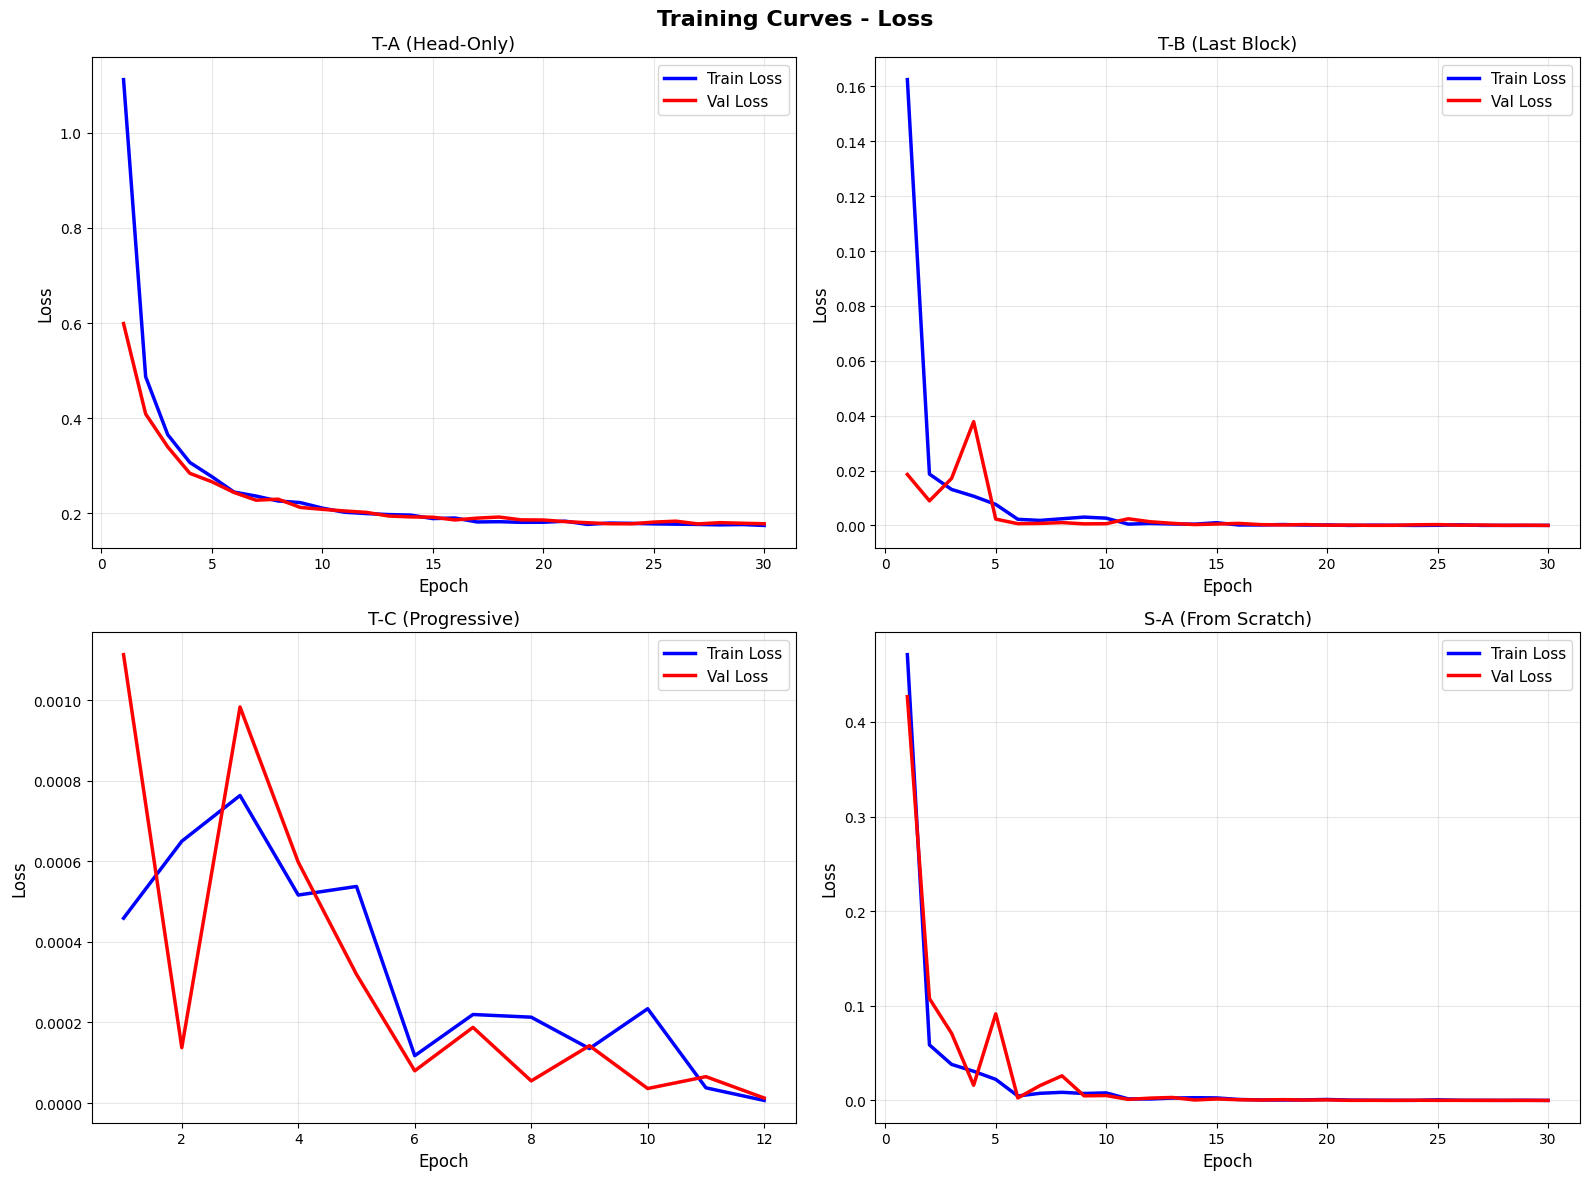

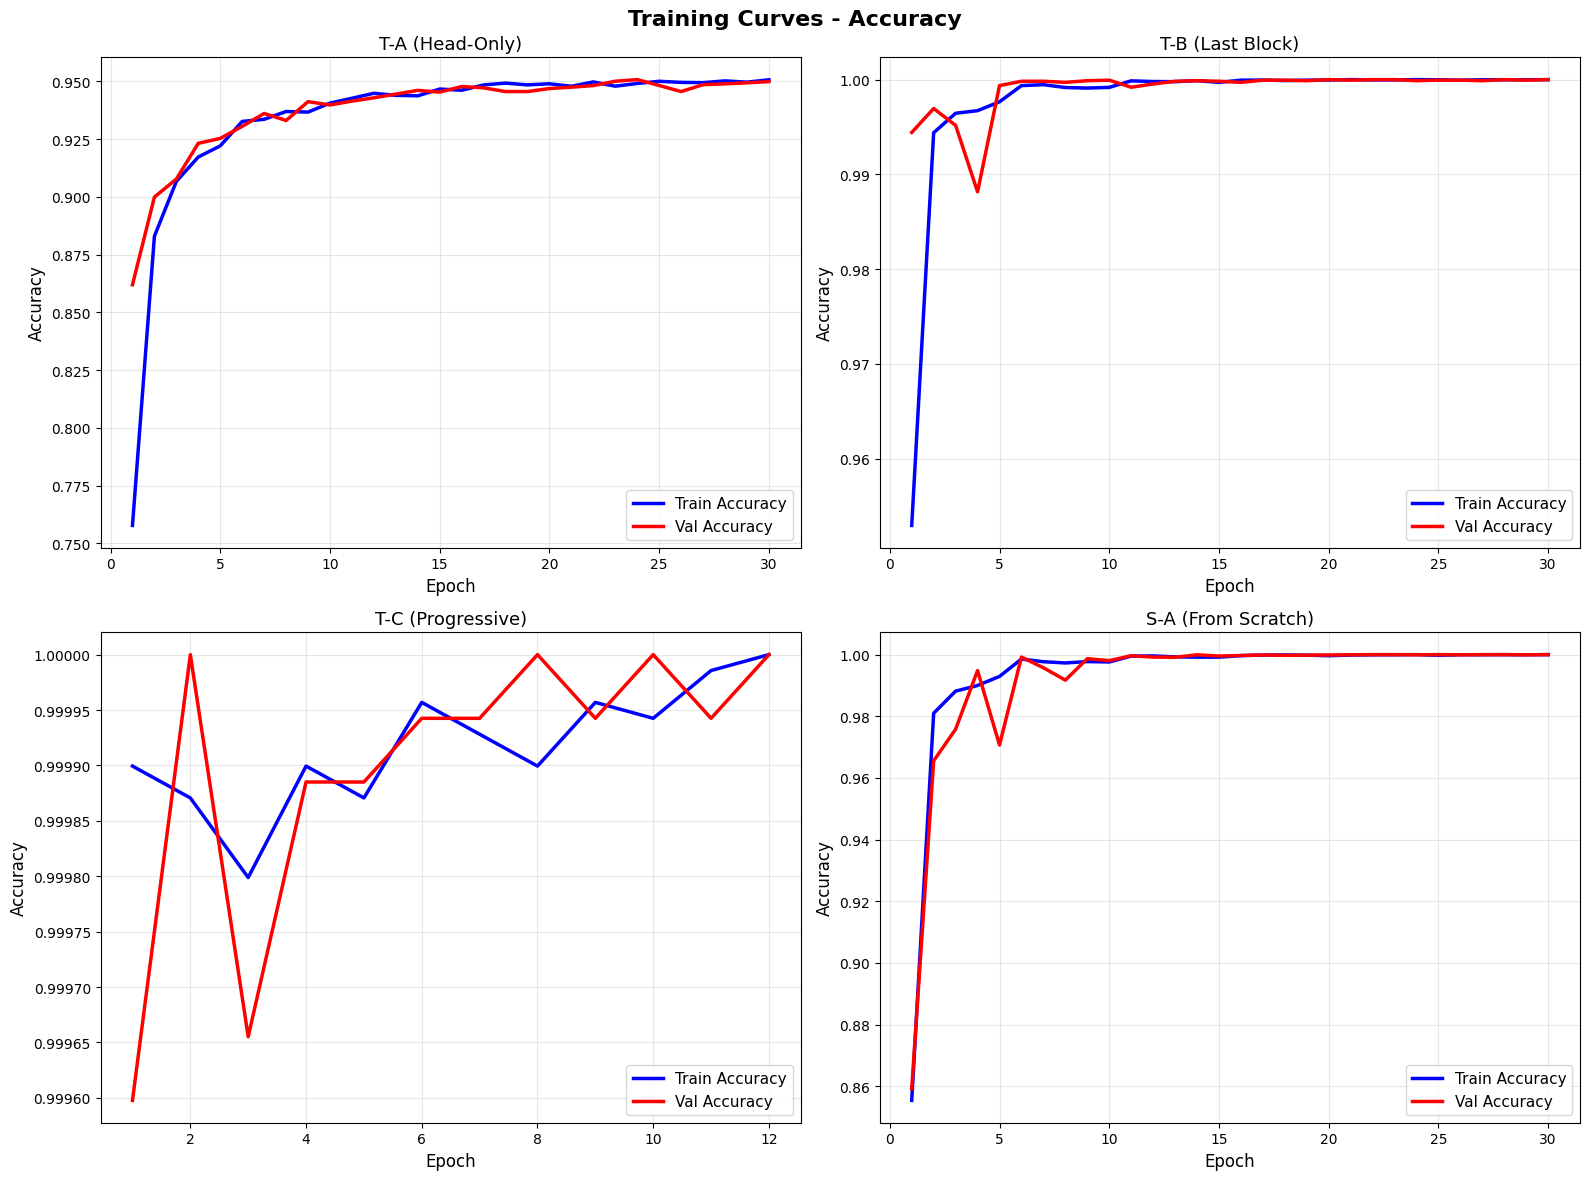

In [19]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training Curves - Loss', fontsize=16, fontweight='bold')

model_names = ['T-A (Head-Only)', 'T-B (Last Block)', 'T-C (Progressive)', 'S-A (From Scratch)']
histories = [history_ta, history_tb, history_tc, history_sa]

for idx, (name, history) in enumerate(zip(model_names, histories)):
    ax = axes[idx // 2, idx % 2]
    epochs = range(1, len(history['train_loss']) + 1)
    ax.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2.5)
    ax.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2.5)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title(name, fontsize=13)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training Curves - Accuracy', fontsize=16, fontweight='bold')

for idx, (name, history) in enumerate(zip(model_names, histories)):
    ax = axes[idx // 2, idx % 2]
    epochs = range(1, len(history['train_acc']) + 1)
    ax.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2.5)
    ax.plot(epochs, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2.5)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title(name, fontsize=13)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()



Testing on original test set (28 images)...


Test Accuracy: 1.0000
Test Macro-F1: 1.0000


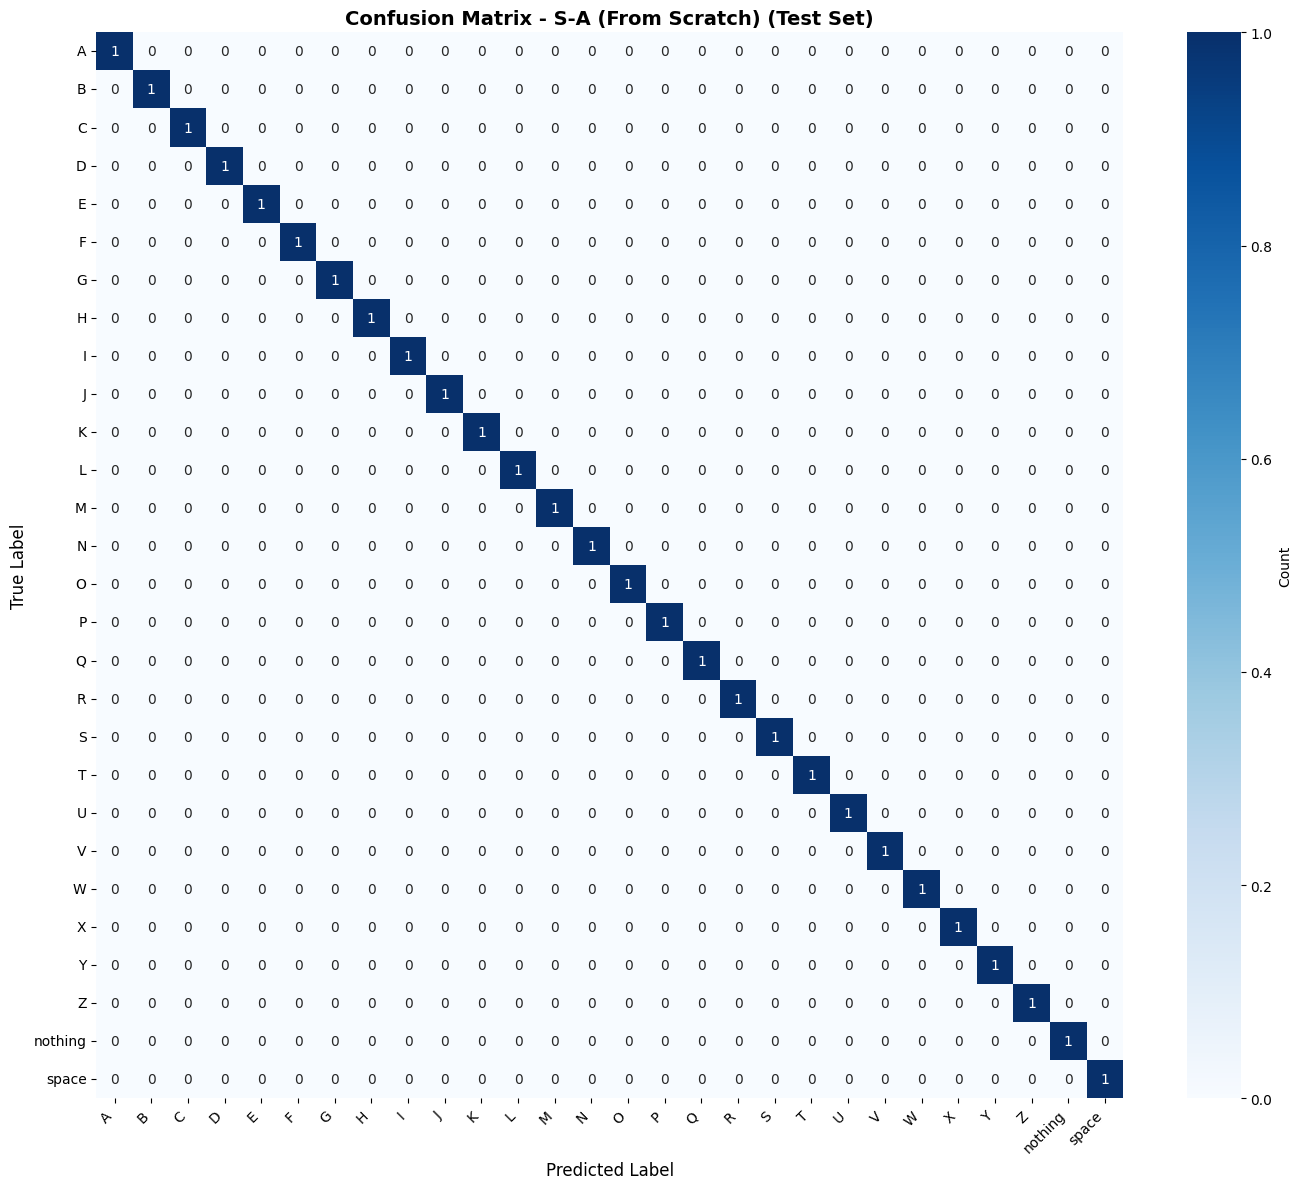

In [20]:
# Test on original test set
print("\nTesting on original test set (28 images)...")
test_loss, test_acc, test_f1, test_preds, test_labels = validate(best_model, test_loader, nn.CrossEntropyLoss(), device)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro-F1: {test_f1:.4f}")

cm = confusion_matrix(test_labels, test_preds)
unique_test_classes = sorted(set(test_labels))
test_class_names = [class_names[i] for i in unique_test_classes]

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_class_names, yticklabels=test_class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
plt.close()

test_results_best = {
    'loss': test_loss,
    'accuracy': test_acc,
    'macro_f1': test_f1,
    'preds': test_preds,
    'labels': test_labels,
    'confusion_matrix': cm
}



Creating custom test set (20 images, 20 classes)...
Testing on custom test set...


Custom Test Accuracy: 1.0000
Custom Test Macro-F1: 1.0000


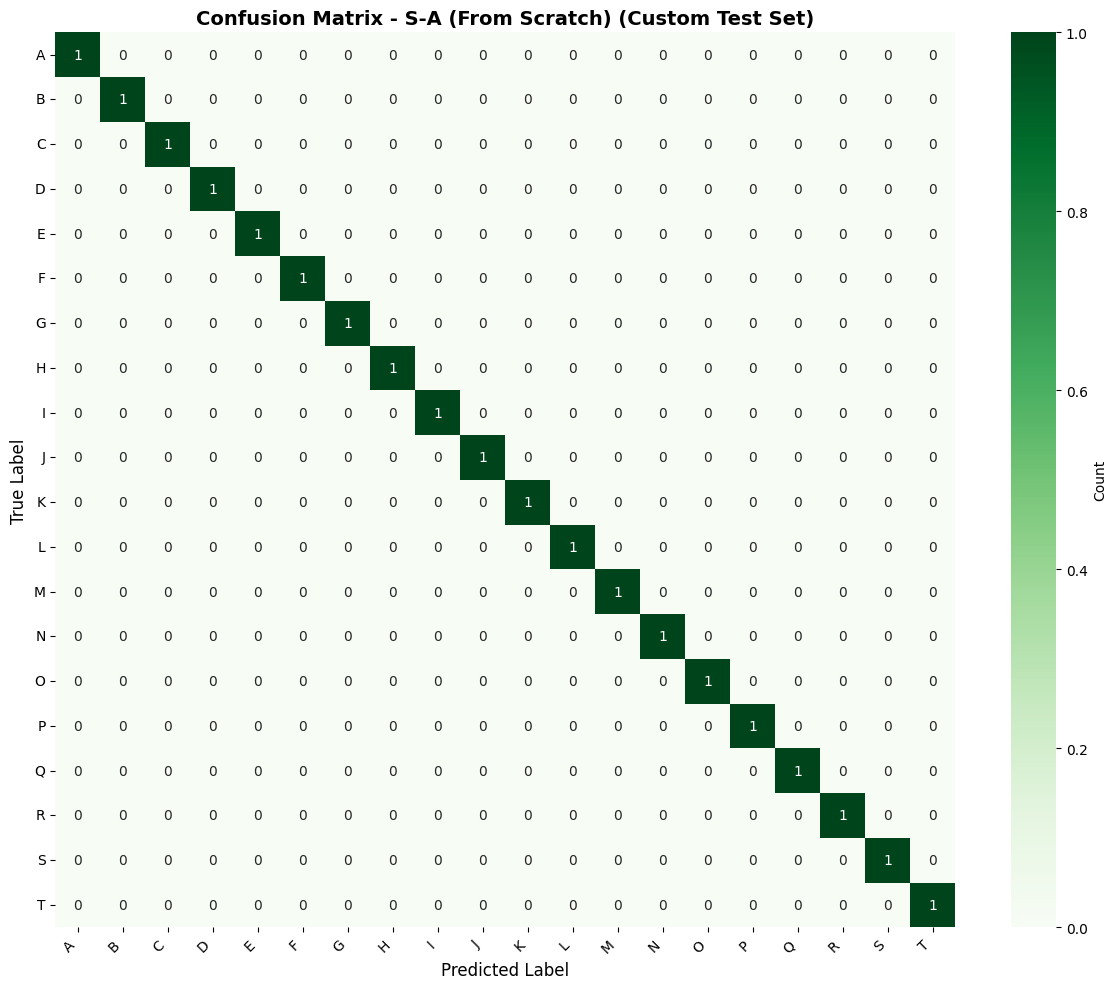

In [21]:
# Test on custom test set
print("\nCreating custom test set (20 images, 20 classes)...")

custom_test_images = []
custom_test_labels = []
custom_selected_classes = set()

for idx in range(len(full_test)):
    if len(custom_test_images) >= 20:
        break

    img, label = full_test[idx]
    class_count = sum(1 for l in custom_test_labels if l == label)

    if class_count < 2:
        custom_test_images.append(img)
        custom_test_labels.append(label)
        custom_selected_classes.add(label)

class SimpleImageTensorDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

custom_test_dataset = SimpleImageTensorDataset(custom_test_images, custom_test_labels)
custom_test_loader = DataLoader(custom_test_dataset, batch_size=16, shuffle=False)

print("Testing on custom test set...")
custom_loss, custom_acc, custom_f1, custom_preds, custom_labels = validate(best_model, custom_test_loader, nn.CrossEntropyLoss(), device)

print(f"Custom Test Accuracy: {custom_acc:.4f}")
print(f"Custom Test Macro-F1: {custom_f1:.4f}")

cm_custom = confusion_matrix(custom_labels, custom_preds)
custom_unique_classes = sorted(set(custom_labels))
custom_class_names = [class_names[i] for i in custom_unique_classes]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Greens',
            xticklabels=custom_class_names, yticklabels=custom_class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name} (Custom Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
plt.close()

In [28]:
# Phase 2
cnn_feature_extractor = resnet18(weights=None)
cnn_feature_extractor.fc = nn.Linear(512, num_classes)
cnn_feature_extractor.load_state_dict(model_tc.state_dict())

cnn_feature_extractor.fc = nn.Identity()
cnn_feature_extractor = cnn_feature_extractor.to(device)
cnn_feature_extractor.eval()

for p in cnn_feature_extractor.parameters():
    p.requires_grad = False

In [29]:
# Define VideoFeatureDataset
class VideoFeatureDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, max_frames=32, transform=None, device='cuda'):
        self.root_dir = root_dir
        self.max_frames = max_frames
        self.transform = transform
        self.device = device

        self.classes = sorted([d for d in os.listdir(root_dir)
                               if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        self.video_paths = []
        self.labels = []

        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for f in os.listdir(cls_dir):
                if f.endswith(('.mp4', '.avi', '.mov', '.mkv')):
                    self.video_paths.append(os.path.join(cls_dir, f))
                    self.labels.append(self.class_to_idx[cls])

        print(f"{os.path.basename(root_dir)}: {len(self.video_paths)} videos, {len(self.classes)} classes")

    def __len__(self):
        return len(self.video_paths)

    def _sample_frame_indices(self, num_frames_total):
        if num_frames_total <= 0:
            return []
        if num_frames_total <= self.max_frames:
            return list(range(num_frames_total))
        else:
            indices = np.linspace(0, num_frames_total - 1, self.max_frames, dtype=int)
            return indices.tolist()

    def _load_and_process_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        num_frames_total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = self._sample_frame_indices(num_frames_total)

        frames = []
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                continue
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(frame)
            if self.transform is not None:
                img = self.transform(img)
            frames.append(img)

        cap.release()

        if len(frames) == 0:
            frames = [torch.zeros(3, 224, 224)]

        frames = torch.stack(frames, dim=0)
        return frames

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        frames = self._load_and_process_frames(video_path)

        with torch.no_grad():
            frames = frames.to(self.device)
            feats = cnn_feature_extractor(frames)

        T_actual = feats.shape[0]
        D = feats.shape[1]

        if T_actual < self.max_frames:
            pad = torch.zeros(self.max_frames - T_actual, D, device=feats.device)
            feats = torch.cat([feats, pad], dim=0)
        elif T_actual > self.max_frames:
            feats = feats[:self.max_frames]

        return feats.cpu(), label

In [30]:
# Datasets and dataloaders
max_frames = 32
feature_dim = 512

train_wlasl_dir = split_info['train']['path']
val_wlasl_dir = split_info['val']['path']
test_wlasl_dir = split_info['test']['path']

wlasl_transform = val_test_transform

train_wlasl_ds = VideoFeatureDataset(train_wlasl_dir, max_frames=max_frames,
                                     transform=wlasl_transform, device=device)
val_wlasl_ds = VideoFeatureDataset(val_wlasl_dir, max_frames=max_frames,
                                   transform=wlasl_transform, device=device)
test_wlasl_ds = VideoFeatureDataset(test_wlasl_dir, max_frames=max_frames,
                                    transform=wlasl_transform, device=device)

num_wlasl_classes = len(train_wlasl_ds.classes)
print(f"Number of WLASL classes: {num_wlasl_classes}")

batch_size_video = 16

train_wlasl_loader = DataLoader(train_wlasl_ds, batch_size=batch_size_video,
                                shuffle=True, num_workers=0, pin_memory=True)
val_wlasl_loader = DataLoader(val_wlasl_ds, batch_size=batch_size_video,
                              shuffle=False, num_workers=0, pin_memory=True)
test_wlasl_loader = DataLoader(test_wlasl_ds, batch_size=batch_size_video,
                               shuffle=False, num_workers=0, pin_memory=True)

print(f"Train batches: {len(train_wlasl_loader)}, Val batches: {len(val_wlasl_loader)}, Test batches: {len(test_wlasl_loader)}")

train: 1001 videos, 100 classes
val: 242 videos, 100 classes
test: 200 videos, 97 classes
Number of WLASL classes: 100
Train batches: 63, Val batches: 16, Test batches: 13


In [31]:
# Temporal models
class TemporalLSTM(nn.Module):
    def __init__(self, input_size=512, hidden_size=256, num_layers=2, num_classes=100, dropout=0.3):
        super(TemporalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=dropout, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        out = self.dropout(last_output)
        out = self.fc(out)
        return out

class TemporalTransformer(nn.Module):
    def __init__(self, input_size=512, num_heads=8, num_layers=2, num_classes=100, dropout=0.3):
        super(TemporalTransformer, self).__init__()
        self.embedding = nn.Linear(input_size, input_size)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_size, nhead=num_heads, dim_feedforward=1024,
            dropout=dropout, batch_first=True, activation='relu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        out = self.dropout(x)
        out = self.fc(out)
        return out

In [32]:
# Training function for temporal models
def train_temporal_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for features, labels in tqdm(loader, desc="Training", leave=False):
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, acc, f1

def validate_temporal(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in tqdm(loader, desc="Validating", leave=False):
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, acc, f1, all_preds, all_labels

def train_temporal_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                        num_epochs, device, model_name, patience=10):
    best_f1 = 0
    patience_counter = 0

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    for epoch in range(num_epochs):
        train_loss, train_acc, train_f1 = train_temporal_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_f1, _, _ = validate_temporal(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        if scheduler:
            scheduler.step()

        if val_f1 > best_f1:
            best_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), f"/content/{model_name}_best.pth")
            print(f"Epoch {epoch+1:2d}/{num_epochs} | Train: L={train_loss:.4f} A={train_acc:.4f} F1={train_f1:.4f} | Val: L={val_loss:.4f} A={val_acc:.4f} F1={val_f1:.4f} (Best)")
        else:
            patience_counter += 1
            print(f"Epoch {epoch+1:2d}/{num_epochs} | Train: L={train_loss:.4f} A={train_acc:.4f} F1={train_f1:.4f} | Val: L={val_loss:.4f} A={val_acc:.4f} F1={val_f1:.4f}")
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(torch.load(f"/content/{model_name}_best.pth"))
    return model, history

In [ ]:
# Train Phase 2A (Freeze CNN, train temporal head)
temporal_2a = TemporalLSTM(input_size=512, hidden_size=256, num_layers=2,
                           num_classes=num_wlasl_classes, dropout=0.3)
temporal_2a = temporal_2a.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(temporal_2a.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

temporal_2a, history_2a = train_temporal_model(
    temporal_2a, train_wlasl_loader, val_wlasl_loader, criterion, optimizer, scheduler,
    num_epochs=25, device=device, model_name="temporal_2a", patience=10
)

Epoch  1/25 | Train: L=4.6526 A=0.0060 F1=0.0012 | Val: L=4.6169 A=0.0083 F1=0.0009 (Best)


Epoch  2/25 | Train: L=4.6182 A=0.0110 F1=0.0021 | Val: L=4.6020 A=0.0124 F1=0.0010 (Best)


Epoch  3/25 | Train: L=4.5906 A=0.0150 F1=0.0020 | Val: L=4.6192 A=0.0248 F1=0.0013 (Best)


Training:  95%|█████████▌| 60/63 [11:02<00:30, 10.01s/it]

In [ ]:
# Train Phase 2B (Unfreeze Layer4, train temporal head)
cnn_2b = resnet18(weights=None)
cnn_2b.fc = nn.Linear(512, num_classes)
cnn_2b.load_state_dict(model_tc.state_dict())

for param in cnn_2b.conv1.parameters():
    param.requires_grad = False
for param in cnn_2b.bn1.parameters():
    param.requires_grad = False
for param in cnn_2b.layer1.parameters():
    param.requires_grad = False
for param in cnn_2b.layer2.parameters():
    param.requires_grad = False
for param in cnn_2b.layer3.parameters():
    param.requires_grad = False

cnn_2b.fc = nn.Identity()
cnn_2b = cnn_2b.to(device)

temporal_2b = TemporalLSTM(input_size=512, hidden_size=256, num_layers=2,
                           num_classes=num_wlasl_classes, dropout=0.3)
temporal_2b = temporal_2b.to(device)

class CombinedTemporalModel(nn.Module):
    def __init__(self, cnn, temporal):
        super(CombinedTemporalModel, self).__init__()
        self.cnn = cnn
        self.temporal = temporal

    def forward(self, x):
        return self.temporal(x)

combined_2b = CombinedTemporalModel(cnn_2b, temporal_2b)

def train_combined_epoch(model, cnn, loader, criterion, optimizer, device):
    cnn.train()
    model.temporal.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for features, labels in tqdm(loader, desc="Training", leave=False):
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, acc, f1

def validate_combined(model, cnn, loader, criterion, device):
    cnn.eval()
    model.temporal.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in tqdm(loader, desc="Validating", leave=False):
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return avg_loss, acc, f1, all_preds, all_labels

best_f1_2b = 0
patience_counter = 0
history_2b = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_f1': [], 'val_f1': []}

for epoch in range(25):
    train_loss, train_acc, train_f1 = train_combined_epoch(combined_2b, cnn_2b, train_wlasl_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1, _, _ = validate_combined(combined_2b, cnn_2b, val_wlasl_loader, criterion, device)

    history_2b['train_loss'].append(train_loss)
    history_2b['val_loss'].append(val_loss)
    history_2b['train_acc'].append(train_acc)
    history_2b['val_acc'].append(val_acc)
    history_2b['train_f1'].append(train_f1)
    history_2b['val_f1'].append(val_f1)

    if scheduler:
        scheduler.step()

    if val_f1 > best_f1_2b:
        best_f1_2b = val_f1
        patience_counter = 0
        torch.save(combined_2b.state_dict(), "/content/combined_2b_best.pth")
        print(f"Epoch {epoch+1:2d}/25 | Train: L={train_loss:.4f} A={train_acc:.4f} F1={train_f1:.4f} | Val: L={val_loss:.4f} A={val_acc:.4f} F1={val_f1:.4f} (Best)")
    else:
        patience_counter += 1
        print(f"Epoch {epoch+1:2d}/25 | Train: L={train_loss:.4f} A={train_acc:.4f} F1={train_f1:.4f} | Val: L={val_loss:.4f} A={val_acc:.4f} F1={val_f1:.4f}")
        if patience_counter >= 10:
            print(f"Early stopping at epoch {epoch+1}")
            break

combined_2b.load_state_dict(torch.load("/content/combined_2b_best.pth"))

In [ ]:
# Evaluate both temporal models on test set
temporal_2a.eval()
test_preds_2a = []
test_labels_2a = []

with torch.no_grad():
    for features, labels in tqdm(test_wlasl_loader, desc="Testing 2A"):
        features, labels = features.to(device), labels.to(device)
        outputs = temporal_2a(features)
        _, preds = torch.max(outputs, 1)
        test_preds_2a.extend(preds.cpu().numpy())
        test_labels_2a.extend(labels.cpu().numpy())

test_acc_2a = accuracy_score(test_labels_2a, test_preds_2a)
test_f1_2a = f1_score(test_labels_2a, test_preds_2a, average='macro', zero_division=0)

print(f"\nPhase 2A Results:")
print(f"  Test Accuracy: {test_acc_2a:.4f}")
print(f"  Test Macro-F1: {test_f1_2a:.4f}")

cm_2a = confusion_matrix(test_labels_2a, test_preds_2a)

combined_2b.temporal.eval()
cnn_2b.eval()
test_preds_2b = []
test_labels_2b = []

with torch.no_grad():
    for features, labels in tqdm(test_wlasl_loader, desc="Testing 2B"):
        features, labels = features.to(device), labels.to(device)
        outputs = combined_2b(features)
        _, preds = torch.max(outputs, 1)
        test_preds_2b.extend(preds.cpu().numpy())
        test_labels_2b.extend(labels.cpu().numpy())

test_acc_2b = accuracy_score(test_labels_2b, test_preds_2b)
test_f1_2b = f1_score(test_labels_2b, test_preds_2b, average='macro', zero_division=0)

print(f"\nPhase 2B Results:")
print(f"  Test Accuracy: {test_acc_2b:.4f}")
print(f"  Test Macro-F1: {test_f1_2b:.4f}")

cm_2b = confusion_matrix(test_labels_2b, test_preds_2b)

if test_f1_2a > test_f1_2b:
    best_temporal_name = "2A"
    best_temporal_f1 = test_f1_2a
else:
    best_temporal_name = "2B"
    best_temporal_f1 = test_f1_2b

print(f"\nBest temporal model: Phase {best_temporal_name} (F1: {best_temporal_f1:.4f})")

In [ ]:
# Plot Phase 2 training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(history_2a['train_loss'], 'b-', label='2A Train Loss', linewidth=2)
axes[0].plot(history_2a['val_loss'], 'b--', label='2A Val Loss', linewidth=2)
axes[0].plot(history_2b['train_loss'], 'r-', label='2B Train Loss', linewidth=2)
axes[0].plot(history_2b['val_loss'], 'r--', label='2B Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_2a['train_f1'], 'b-', label='2A Train F1', linewidth=2)
axes[1].plot(history_2a['val_f1'], 'b--', label='2A Val F1', linewidth=2)
axes[1].plot(history_2b['train_f1'], 'r-', label='2B Train F1', linewidth=2)
axes[1].plot(history_2b['val_f1'], 'r--', label='2B Val F1', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Macro-F1')
axes[1].set_title('Training & Validation Macro-F1')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()